# **Retinal Implants II: Threshold Detection**
<br>
Tasks Done In Demo:<br>

Familiarizing with the dataset(Horsager et al. (2009))<br>


In [2]:
%matplotlib inline
#Use/uncomment below distribution installations only during environment setup else comment it 
#!pip install pulse2percept
#!pip install --upgrade numpy

## Loading the dataset

The dataset can be loaded as a Pandas ``DataFrame``:

In [3]:
from pulse2percept.datasets import load_horsager2009
data = load_horsager2009()
#data.describe()
#print(data)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
print("`{}` patients, subject: {}".format(len(data.subject.unique()),data.subject.unique()))

`2` patients, subject: ['S05' 'S06']


**Electrodes that were tested for which subject**

9 electrodes were used to test each subject {`C3`,`A1`,`B3`,`C2`,`B1`,`C4`,`B2`,`D1`,`A2`}

In [5]:
for i in data.electrode.unique():
  print(i,end=", ")

C3, A1, B3, C2, B1, C4, B2, D1, A2, 


Different stimulus types used

7 types of stimulus were used in this research, They are {`single_pulse`, `fixed_duration`, `variable_duration`, `fixed_duration_supra`, `bursting_triplets`, `bursting_triplets_supra`, `latent_addition`}

In [6]:
for i in data.stim_type.unique():
  print(i,end=", ")

single_pulse, fixed_duration, variable_duration, fixed_duration_supra, bursting_triplets, bursting_triplets_supra, latent_addition, 

In [7]:
#using single_pulse data
singlePulseData=data[data['stim_type']=='single_pulse']
#singlePulseData=data.loc[(data['stim_type']=='single_pulse') & (data['task']=='threshold')]


#Patient with max threshold current Pulse Duration used
paMaxThres=singlePulseData[singlePulseData['stim_amp'] == singlePulseData['stim_amp'].max()]
print("Patient with highest threshold current = {} and Electrode stimulation done with the electrode {}. Max threshold current obtained is {}"
.format(paMaxThres.subject.to_string(index = False),paMaxThres.electrode.to_string(index = False),paMaxThres['stim_amp'].to_string(index = False)))
print("Pulse Duration used = {}".format(paMaxThres.pulse_dur.to_string(index = False)))

#Patient with min threshold Current and Pulse Duration used
paMinThres=singlePulseData[singlePulseData['stim_amp'] == singlePulseData['stim_amp'].min()]
print("Patient with lowest threshold current = {} and Electrode stimulation done with the electrode {}. Min threshold current obtained is {}"
.format(paMinThres.subject.to_string(index = False),paMinThres.electrode.to_string(index = False),paMinThres['stim_amp'].to_string(index = False)))
print("Pulse Duration used = {}".format(paMinThres.pulse_dur.to_string(index = False)))
#singlePulseData[singlePulseData['stim_amp'] == singlePulseData['stim_amp'].max()]

Patient with highest threshold current = S06 and Electrode stimulation done with the electrode D1. Max threshold current obtained is 445.880312
Pulse Duration used = 0.075
Patient with lowest threshold current = S05 and Electrode stimulation done with the electrode C2. Min threshold current obtained is 11.466683
Pulse Duration used = 4.0


In [8]:
import numpy as np
s06SPEc2=data.loc[(data['subject']=='S06') & (data['electrode']=='C2') & (data['stim_type']=='single_pulse')]
#s06SPEc2 = load_horsager2009(subjects='S06', electrodes='C2',stim_types='single_pulse')

We want to find the threshold of seeing a stimulus 50% of the time with our
model. Since for the model we cannot define the threshold as ‘seeing
something 50% of the time’, a constant threshold is defined that the model
needs to reach. This threshold is found in the column ‘theta’ in the dataset.
<br>

In [9]:
print("The Value of  constant threshold for a stimulus 50% with the model {}".format(s06SPEc2['theta'].iloc[0]))

from pulse2percept.models import Horsager2009Temporal
model = Horsager2009Temporal()
#Bulding the model to perform all expensive one-time calculations. 
model.build()

The Value of  constant threshold for a stimulus 50% with the model 1612.5


Horsager2009Temporal(beta=3.43, dt=0.005, eps=2.25, 
                     n_threads=8, tau1=0.42, tau2=45.25, 
                     tau3=26.25, thresh_percept=0, 
                     verbose=True)

In [10]:
s06SPEc2.reset_index(drop=True, inplace=True)
stim_amp_old=[s06SPEc2['stim_amp']]
stim_amp_old

[0    382.788226
 1    222.807475
 2    153.103322
 3     82.706060
 4     69.113388
 5     44.675045
 6     31.398787
 7     24.534255
 Name: stim_amp, dtype: float64]

Now we loop over each row of the dataframe and define the stimulus as a
BiphasicPulse with pulse duration, interphase duration and stimulus duration
as set in this row of the dataframe. Set the initial value of the amplitude to
1uA.<br>


We now want to alter the amplitude so that the model output matches theta
as closely as possible. Search amplitudes [0, 300] uA. Stop the search once
the amplitudes are within 1uA or within 0.1 of theta. Save the found
amplitude for each row. 

In [11]:
from pulse2percept.stimuli import BiphasicPulse
stim_amp_alt = [] #Array to store found amplitude for each row iteration.
for index, row in s06SPEc2.iterrows():
    
    stim = BiphasicPulse(1, row['pulse_dur'],interphase_dur=row['interphase_dur'],stim_dur=row['stim_dur'],
                         cathodic_first=True,electrode=row['electrode'])
    
    stim_amp_alt.append(model.find_threshold(stim, row['theta'],amp_range=(0, 300), amp_tol=1,bright_tol=0.1))
stim_amp_alt

[299.70703125,
 197.16796875,
 136.23046875,
 65.33203125,
 51.26953125,
 44.23828125,
 30.17578125,
 23.14453125]

<AxesSubplot:xlabel='pulse_dur', ylabel='stim_amp'>

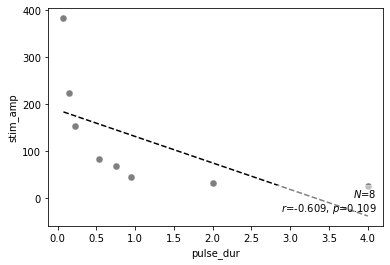

In [12]:
from pulse2percept.viz import scatter_correlation
# Plot the threshold current against pulse duration:experiment
scatter_correlation(s06SPEc2.pulse_dur, s06SPEc2.stim_amp)

<AxesSubplot:xlabel='pulse_dur'>

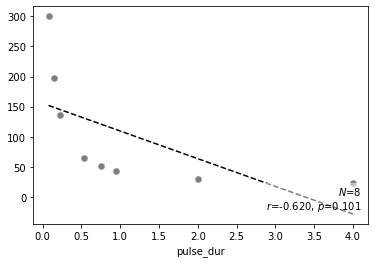

In [13]:
# 4.f.Plot the threshold current against pulse duration:Model
scatter_correlation(s06SPEc2.pulse_dur, stim_amp_alt)

Text(0.5, 1.0, 'Threshold Currents Vs Pulse Duration')

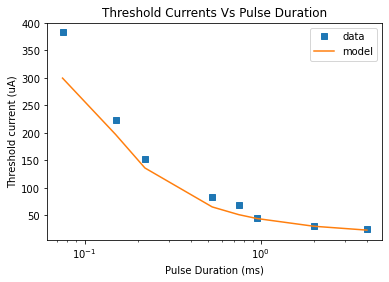

In [14]:
# 4.f.A more sophosticated plotting 
import matplotlib.pyplot as plt
plt.semilogx(s06SPEc2.pulse_dur, s06SPEc2.stim_amp, 's', label='data')
plt.semilogx(s06SPEc2.pulse_dur, stim_amp_alt, label='model')
plt.xlabel('Pulse Duration (ms)')
plt.ylabel('Threshold current (uA)')
plt.legend()
plt.title('Threshold Currents Vs Pulse Duration')